#Automobile Regression Project 
This notebook contains the basic data analysis on the dataset, it contains the generation of the plots and graphs. 

## Authors 
Josep Maria Olivé <br>
Pol Monroig Company 

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# If running in local
#%matplotlib notebook

# If running in colab:
%matplotlib inline

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names): 
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [ ]:
data = pd.read_csv('imports-85.data')
# remove samples without price 
data = data[data['price'] != '?']
# change ? for Nan
data = data.replace('?', np.nan)



In [ ]:
data['price']

Most points are below 20000

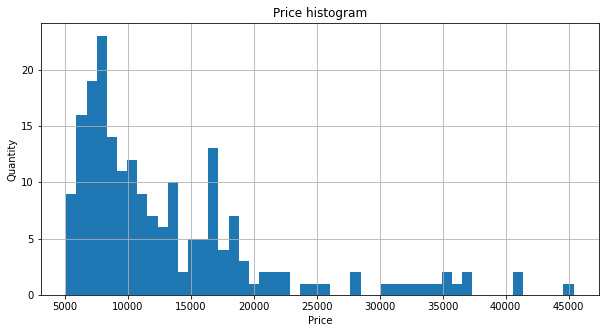

In [ ]:
pd.to_numeric(data['price']).hist(bins=50, figsize=(10, 5))
plt.title('Price histogram')
plt.xlabel('Price')
plt.ylabel('Quantity')
plt.show()

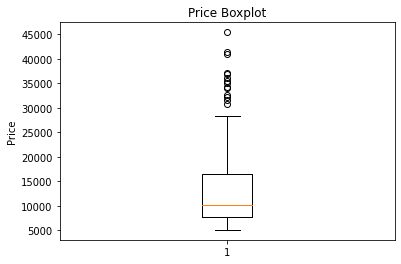

In [ ]:
plt.boxplot(data['price'].astype(float))
plt.title('Price Boxplot')
plt.ylabel('Price')
plt.show()

This is an example of the outlier removal, we decided to keep outliers, tsince they are representative to the datsaet, atn removing them made the size of the dataset much smaller and did not provide any type of improvement. 

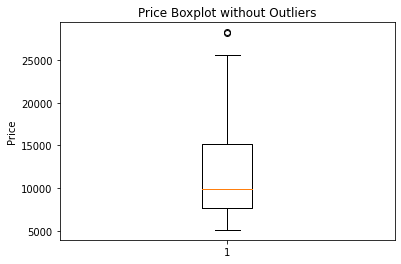

In [ ]:

data_outliers = data[data['price'].astype(float) < 30000]
plt.boxplot(data_outliers['price'].astype(float))
plt.title('Price Boxplot without Outliers')
plt.ylabel('Price')
plt.show()

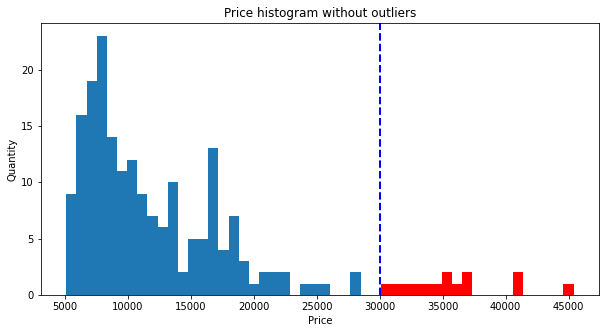

In [ ]:
plt.figure(figsize=(10, 5))
n, bins, patches  = plt.hist(pd.to_numeric(data['price']), bins=50)


for i in range(len(patches[:20])):
    patches[i + 30].set_facecolor('red')
plt.title('Price histogram without outliers')
plt.xlabel('Price')
plt.ylabel('Quantity')
p = plt.axvline(x=30000, color='b', linestyle='dashed', linewidth=2)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


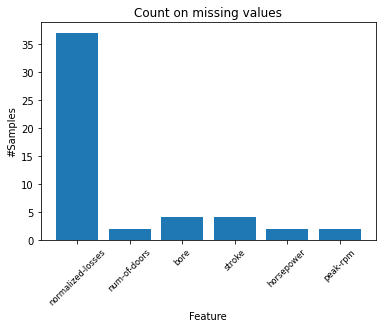

In [ ]:
nans = np.array([data[col].isna().sum() for col in data.columns]) 
nonzero = np.argwhere(nans != 0)
nans_cols = data.columns[nonzero].reshape(-1)

plt.bar(range(len(nans_cols)), nans[nonzero].reshape(-1), align='center')
plt.xticks(range(len(nans_cols)), nans_cols, size='small', rotation=45)
plt.title('Count on missing values')
plt.xlabel('Feature')
plt.ylabel('#Samples')

plt.show()

In [ ]:
numerical_features

['symboling',
 'normalized-losses',
 'wheel-base',
 'length',
 'width',
 'height',
 'curb-weight',
 'engine-size',
 'bore',
 'stroke',
 'compression-ratio',
 'horsepower',
 'peak-rpm',
 'city-mpg',
 'highway-mpg']

In [ ]:
categorical_features = ['make', 'fuel-type', 'aspiration', 
                        'num-of-doors', 'body-style', 
                        'drive-wheels', 'engine-location', 
                        'fuel-system', 'engine-type', 
                        'num-of-cylinders']

prediction_col = 'price'
numerical_features = [col for col in data.columns if not col in categorical_features][:-1]

all_features = numerical_features + categorical_features

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


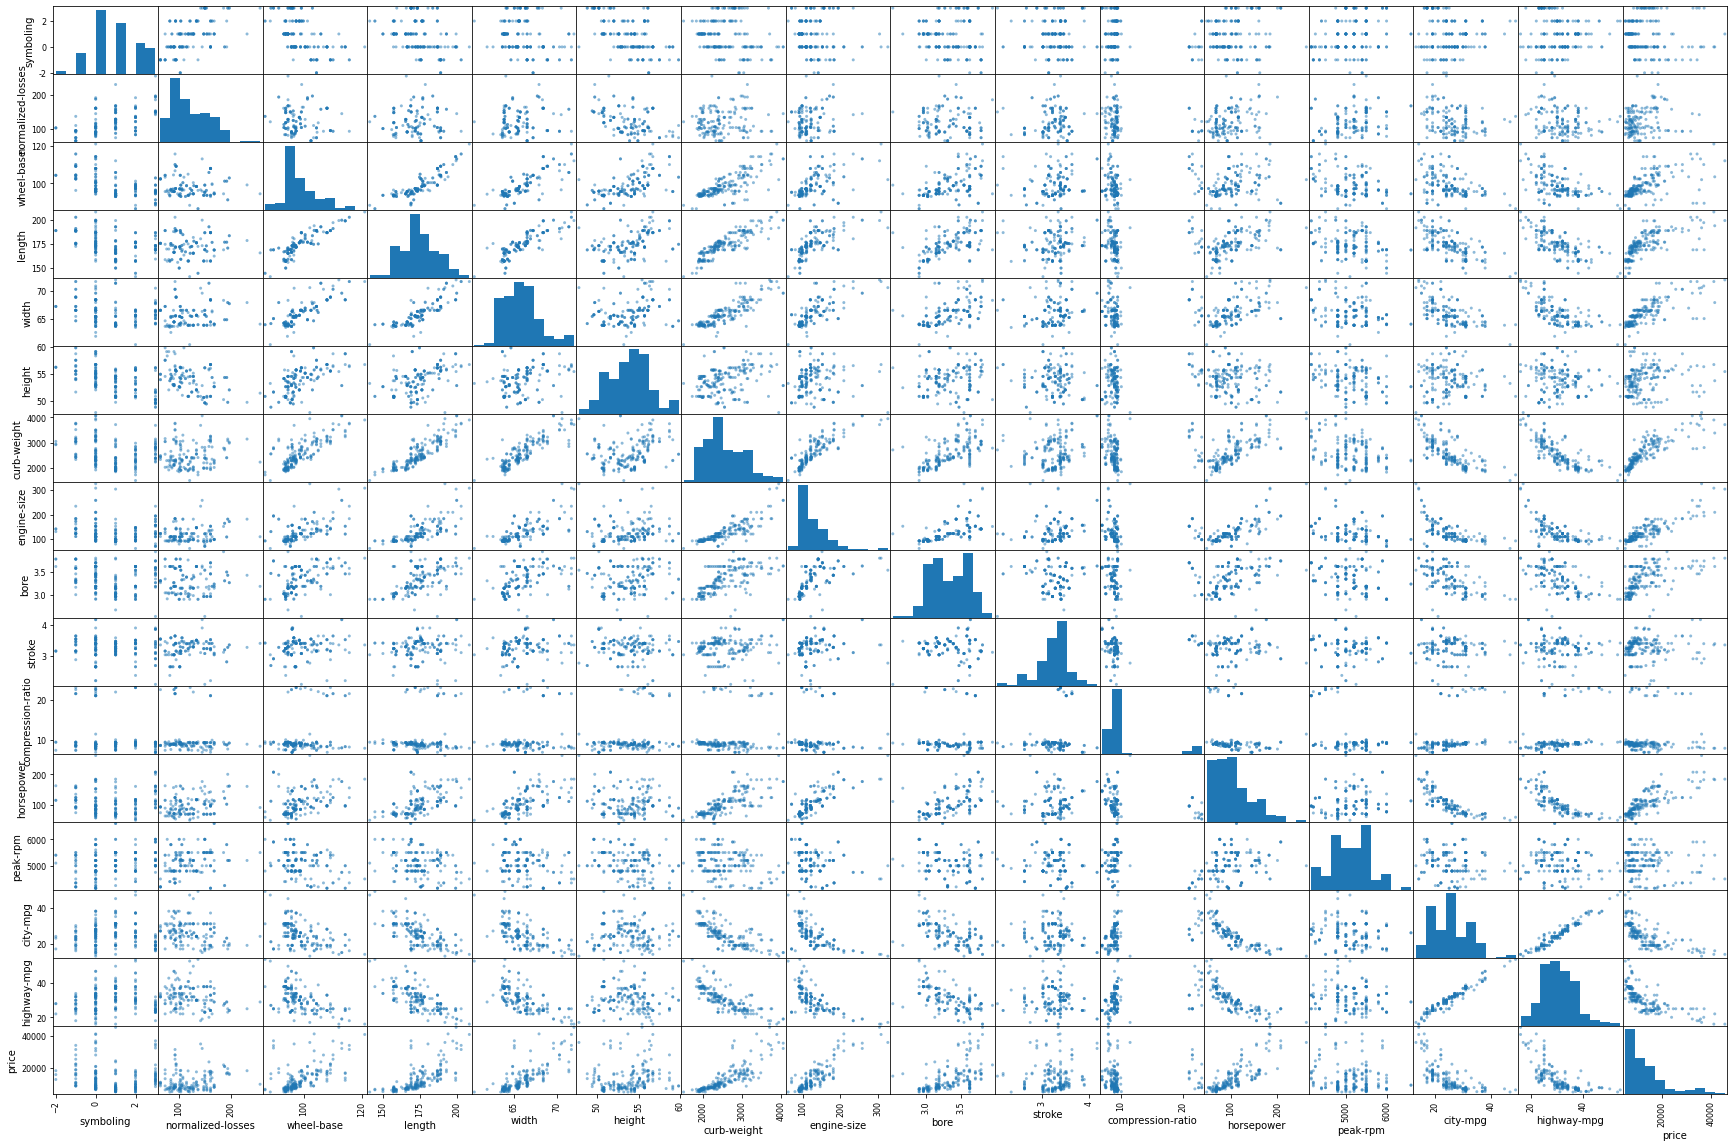

In [ ]:
data_numerical = data[numerical_features+ [prediction_col]]
for col in data_numerical.columns: 
    data_numerical[col] = pd.to_numeric(data_numerical[col])
pd.plotting.scatter_matrix(data_numerical, figsize=(30, 20))
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


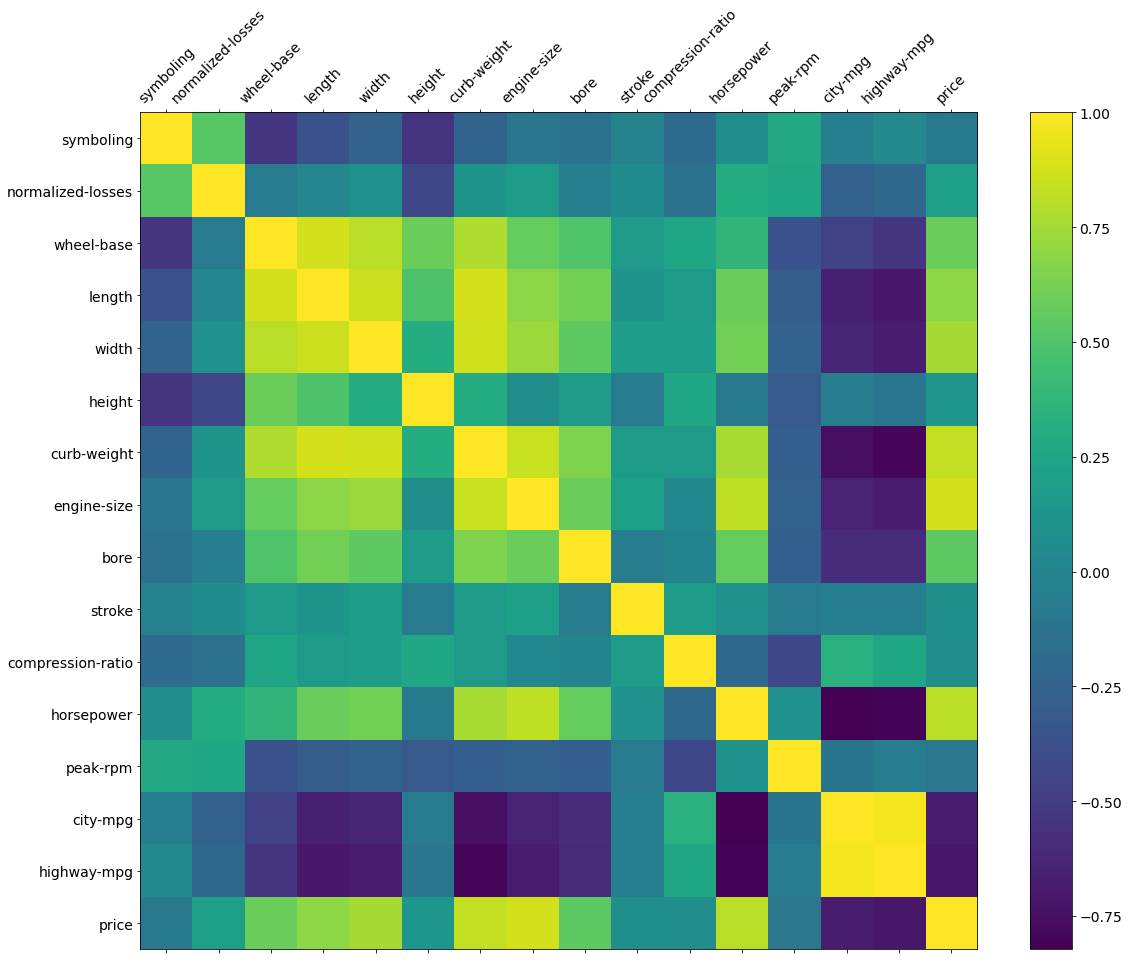

In [ ]:
data_numerical = data[numerical_features + [prediction_col]]
for col in data_numerical.columns: 
    data_numerical[col] = pd.to_numeric(data_numerical[col])
f = plt.figure(figsize=(19, 15))
plt.matshow(data_numerical.corr(), fignum=f.number)
plt.xticks(range(len(data_numerical.columns)), data_numerical.columns, fontsize=14, rotation=45)
plt.yticks(range(len(data_numerical.columns)), data_numerical.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

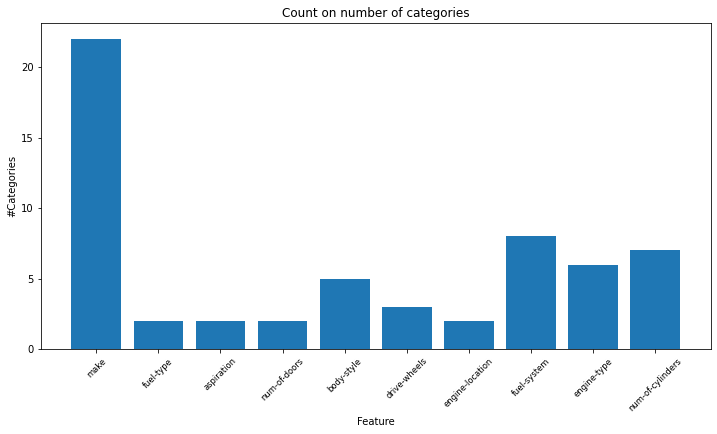

In [ ]:
counts = [len(data[col].value_counts()) for col in categorical_features]

plt.figure(figsize=(12, 6))
plt.bar(range(len(counts)), counts, align='center')
plt.xticks(range(len(counts)), categorical_features, size='small', rotation=45)
plt.title('Count on number of categories')
plt.xlabel('Feature')
plt.ylabel('#Categories')


plt.show()

In [ ]:
data[numerical_features].corr()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,compression-ratio,city-mpg,highway-mpg
symboling,1.000000,-0.535987,-0.365404,-0.242423,-0.550160,-0.233118,-0.110581,-0.182196,-0.035527,0.036233
wheel-base,-0.535987,1.000000,0.876024,0.814507,0.590742,0.782097,0.572027,0.250313,-0.470606,-0.543304
length,-0.365404,0.876024,1.000000,0.857170,0.492063,0.880665,0.685025,0.159733,-0.665192,-0.698142
width,-0.242423,0.814507,0.857170,1.000000,0.306002,0.866201,0.729436,0.189867,-0.633531,-0.680635
height,-0.550160,0.590742,0.492063,0.306002,1.000000,0.307581,0.074694,0.259737,-0.049800,-0.104812
curb-weight,-0.233118,0.782097,0.880665,0.866201,0.307581,1.000000,0.849072,0.156433,-0.749543,-0.794889
engine-size,-0.110581,0.572027,0.685025,0.729436,0.074694,0.849072,1.000000,0.028889,-0.650546,-0.679571
compression-ratio,-0.182196,0.250313,0.159733,0.189867,0.259737,0.156433,0.028889,1.000000,0.331425,0.268465
city-mpg,-0.035527,-0.470606,-0.665192,-0.633531,-0.049800,-0.749543,-0.650546,0.331425,1.000000,0.972044
highway-mpg,0.036233,-0.543304,-0.698142,-0.680635,-0.104812,-0.794889,-0.679571,0.268465,0.972044,1.000000
